In [49]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn


from torch.utils.data.dataset import random_split

from torch import optim

import torch.nn.functional as F


from PIL import Image
import numpy as np
import glob
import os
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score
from sklearn.decomposition import PCA

import datetime

%matplotlib inline
%config InlineBackend.figure_formats = 'retina'
plt.rcParams['figure.figsize'] = [9, 6]
warnings.filterwarnings("ignore")

In [2]:
train_path = "Classification_data/train/"
test_path = "Classification_data/test/"

In [3]:
class2ind = {}
ind2class = {}

In [4]:
for i, folder in enumerate(os.listdir(train_path)):
   ind2class[i]=folder

In [5]:
class2ind={ind2class[i]: i  for i in range(len(ind2class))}

In [6]:
class2ind

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [34]:
def get_data(path):
    data = []
    labels = []
    for folder in glob.glob(path + '/*'):
        for filename in glob.glob(folder + "/*.jpg"):
        # print(filename)
            image = cv2.imread(filename)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            data.append(image)
            label = filename.split('\\')[-2]
            labels.append(class2ind[label])

    return data, labels


In [35]:
train_data, train_labels = get_data(train_path)
test_data, test_labels = get_data(test_path)

In [38]:
def visualise_images(data, labels):
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    idx = np.random.randint(0, len(data), 10)
    for i, index in enumerate(idx):
        axs[i//5, i%5].imshow(data[index])
        axs[i//5, i%5].axis("off")
        title = ind2class[labels[index]]
        axs[i//5, i%5].set_title(f"Class {title}")

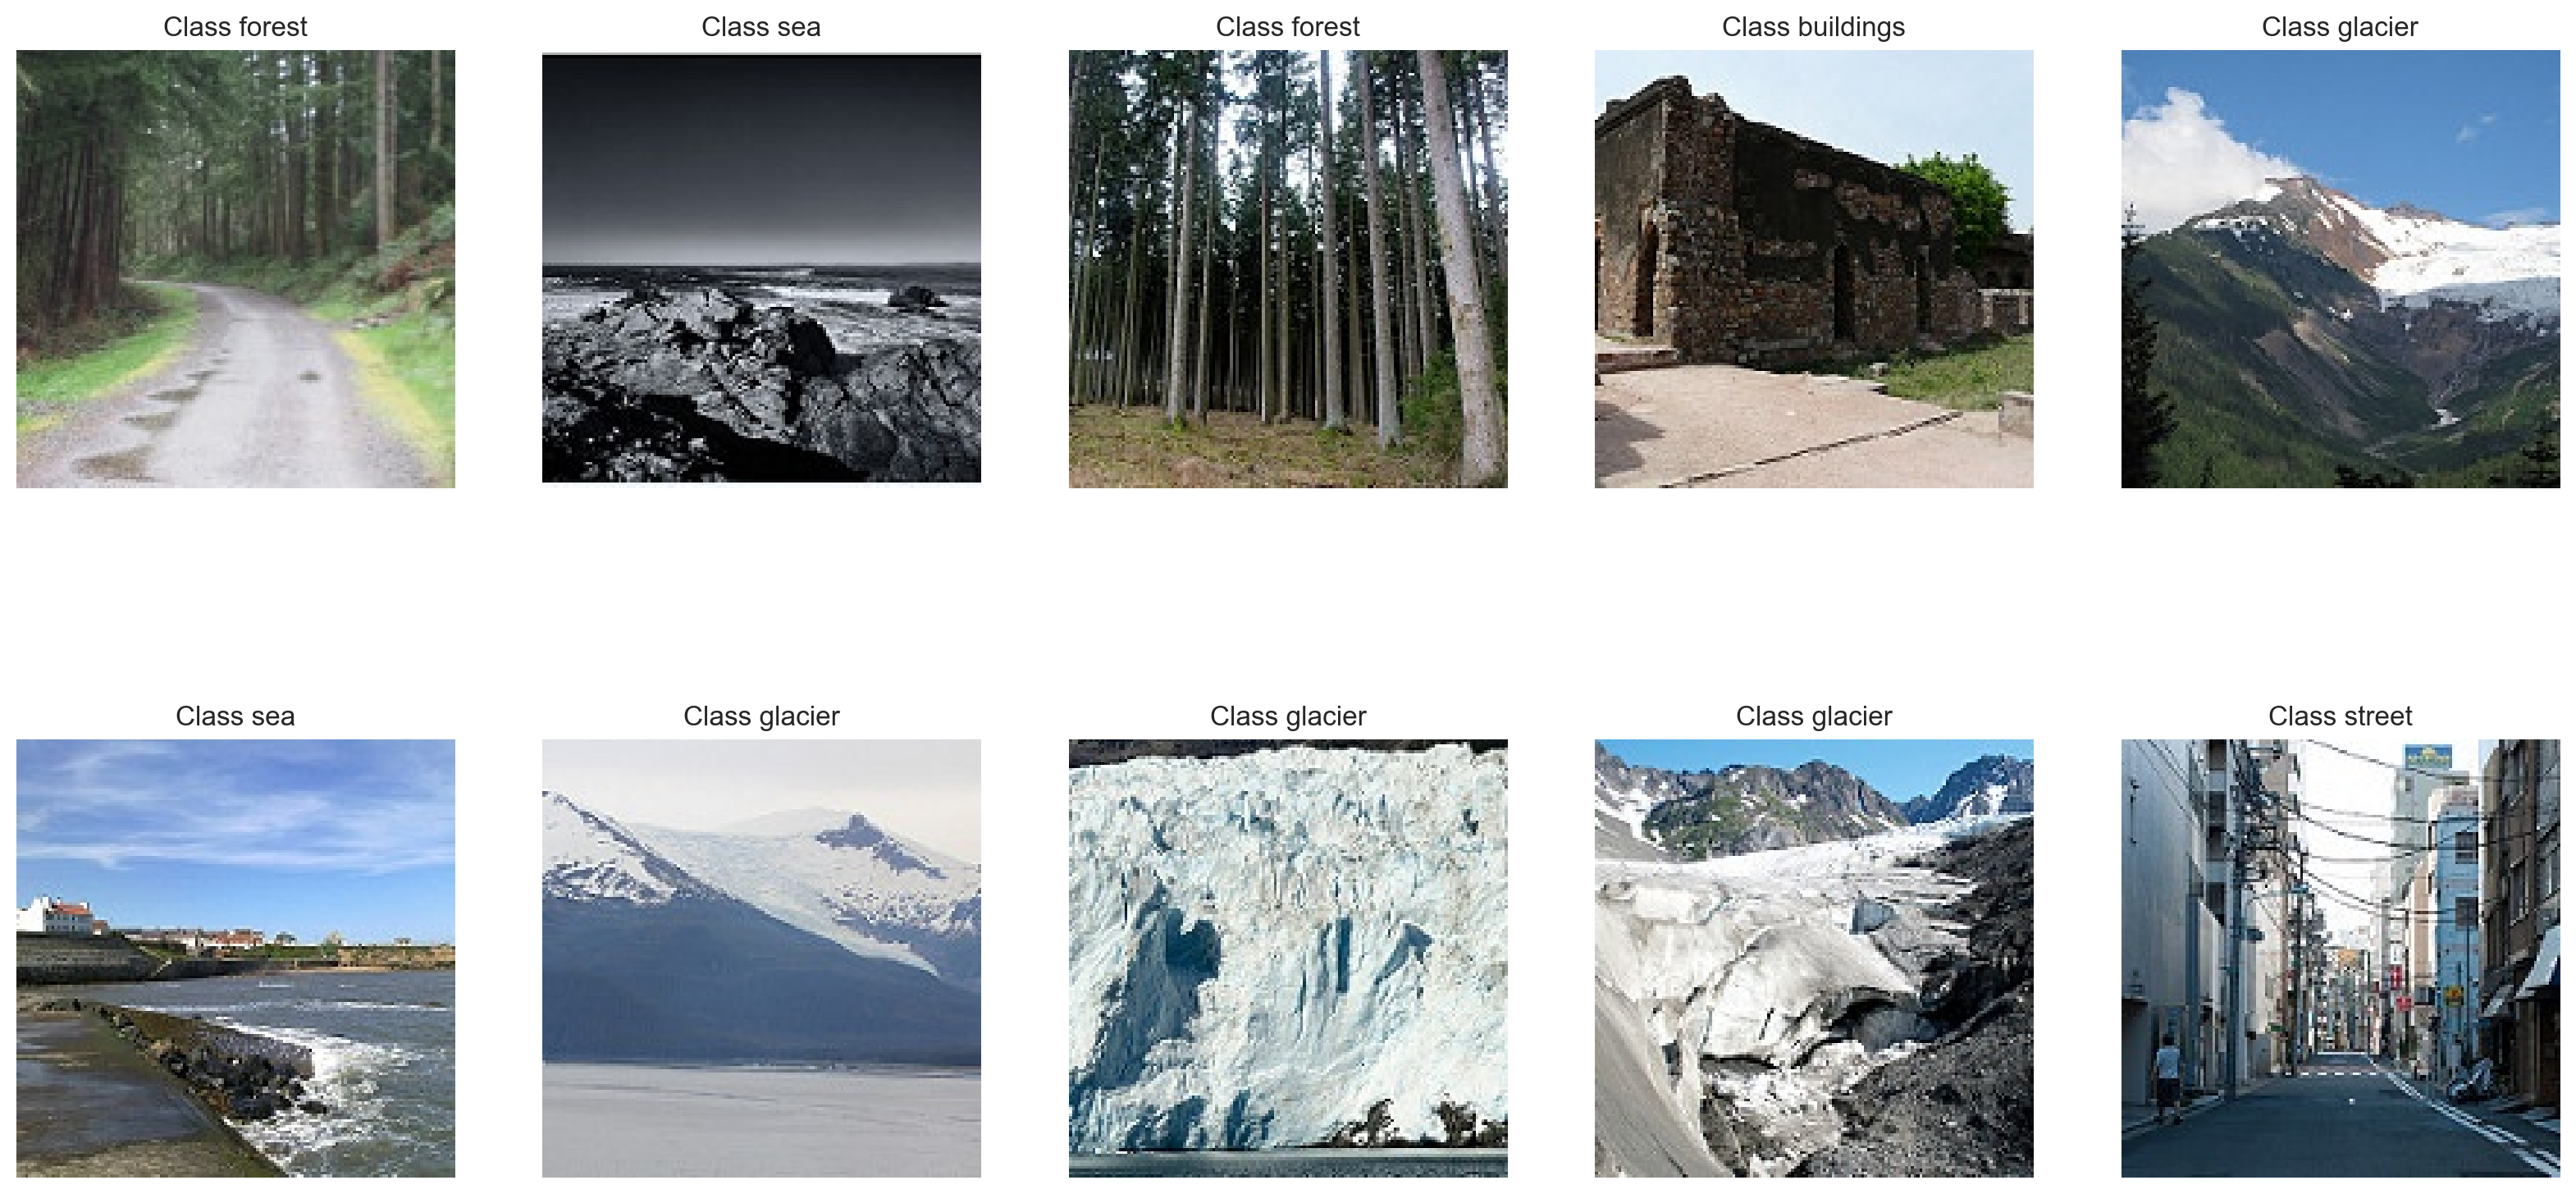

In [39]:
visualise_images(train_data, train_labels)

# Classical approach

For classical features I will use histograms as bag of visual words.
I will create normalized histogram of the whole image, and of its parts:
* dividing the image into 9 subblocks: 50X50 pixels each
* dividing the image into 3 horizontal blocks: 50X150 pixels each
* dividing the image into 3 vertical blocks: 150X50 pixels each
and computing histograms of all of them.

I will use 16 bins. And as it will be done for 3 channels, I will get 3*(3+3+9)*16=720 features.

In [211]:
def calc_hist(img):
    '''
    Simple histogram of 16 bins for each channels
    :return: concatenated histogram of three channels, array of shape (48,1)
    '''
    r_hist = cv2.calcHist(img, [0], None, [16], [0, 256])
    g_hist = cv2.calcHist(img, [1], None, [16], [0, 256])
    b_hist = cv2.calcHist(img, [2], None, [16], [0, 256])


    #normalize histograms
    cv2.normalize(r_hist, r_hist, 0, 1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(g_hist, g_hist, 0, 1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(b_hist, b_hist, 0, 1, norm_type=cv2.NORM_MINMAX)

    #calculate histograms of 9 subblocks of 50X50 length
    # r_subblocks=[]
    # g_subblocks=[]
    # b_subblocks=[]
    # for i in range(3):
    #     for j in range(3):
    #         r_subblocks.append(cv2.calcHist(img[i*50:(i+1)*50, j*50:(j+1)*50], [0], None, [16], [0, 256]))
    #         g_subblocks.append(cv2.calcHist(img[i*50:(i+1)*50, j*50:(j+1)*50], [1], None, [16], [0, 256]))
    #         b_subblocks.append(cv2.calcHist(img[i*50:(i+1)*50, j*50:(j+1)*50], [2], None, [16], [0, 256]))
    #
    # print(len(r_subblocks))
    # print(r_subblocks)
    # #calculate histograms of horizontal blocks (50X150)
    # r_hor = []
    # g_hor = []
    # b_hor = []
    # for i in range(3):
    #     r_hor.append(cv2.calcHist(img[i*50:(i+1)*50, :], [0], None, [16], [0, 256]))
    #     g_hor.append(cv2.calcHist(img[i*50:(i+1)*50,:], [1], None, [16], [0, 256]))
    #     b_hor.append(cv2.calcHist(img[i*50:(i+1)*50, :], [2], None, [16], [0, 256]))
    #
    # #calculate histograms of vertical blocks (50X150)
    # r_vert = []
    # g_vert = []
    # b_vert = []
    # for i in range(3):
    #     r_vert.append(cv2.calcHist(img[:, i*50:(i+1)*50], [0], None, [16], [0, 256]))
    #     g_vert.append(cv2.calcHist(img[:, i*50:(i+1)*50], [1], None, [16], [0, 256]))
    #     b_vert.append(cv2.calcHist(img[:, i*50:(i+1)*50], [2], None, [16], [0, 256]))

    result = np.array(np.vstack([r_hist, g_hist, b_hist])).flatten()


    return result

    # return np.vstack([np.array(r_hist).flatten(),
    #                   np.array(g_hist).flatten(),
    #                   np.array(b_hist).flatten(),
    #                   np.array(r_subblocks).flatten(),
    #                   np.array(g_subblocks).flatten(),
    #                   np.array(b_subblocks).flatten(),
    #                   np.array(r_hor).flatten(),
    #                   np.array(g_hor).flatten(),
    #                   np.array(b_hor).flatten(),
    #                   np.array(r_vert).flatten(),
    #                   np.array(g_vert).flatten(),
    #                   np.array(b_vert).flatten()])

In [212]:
rgb_hist = calc_hist(train_data[1])

In [213]:
print(rgb_hist)

[0.         0.         0.         0.         0.4473684  0.2236842
 0.36842105 0.67105263 0.7236842  0.43421054 0.32894737 1.
 0.7236842  0.36842105 0.6184211  0.01315789 0.         0.
 0.         0.         0.42857143 0.20238096 0.3809524  0.6547619
 0.5595238  0.3452381  0.2857143  1.         0.5833334  0.29761904
 0.47619048 0.14285715 0.         0.         0.         0.
 0.5285714  0.17142858 0.42857143 0.85714287 0.6142857  0.51428574
 0.31428573 0.94285715 1.         0.2857143  0.31428573 0.45714286]


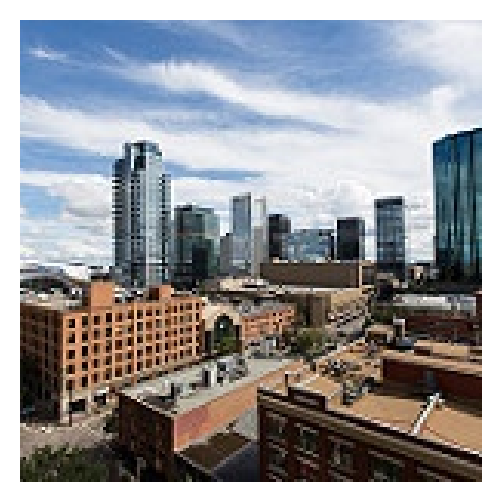

In [214]:
plt.figure(figsize=(5,3))
plt.imshow(train_data[1])
plt.axis("off")
plt.show()

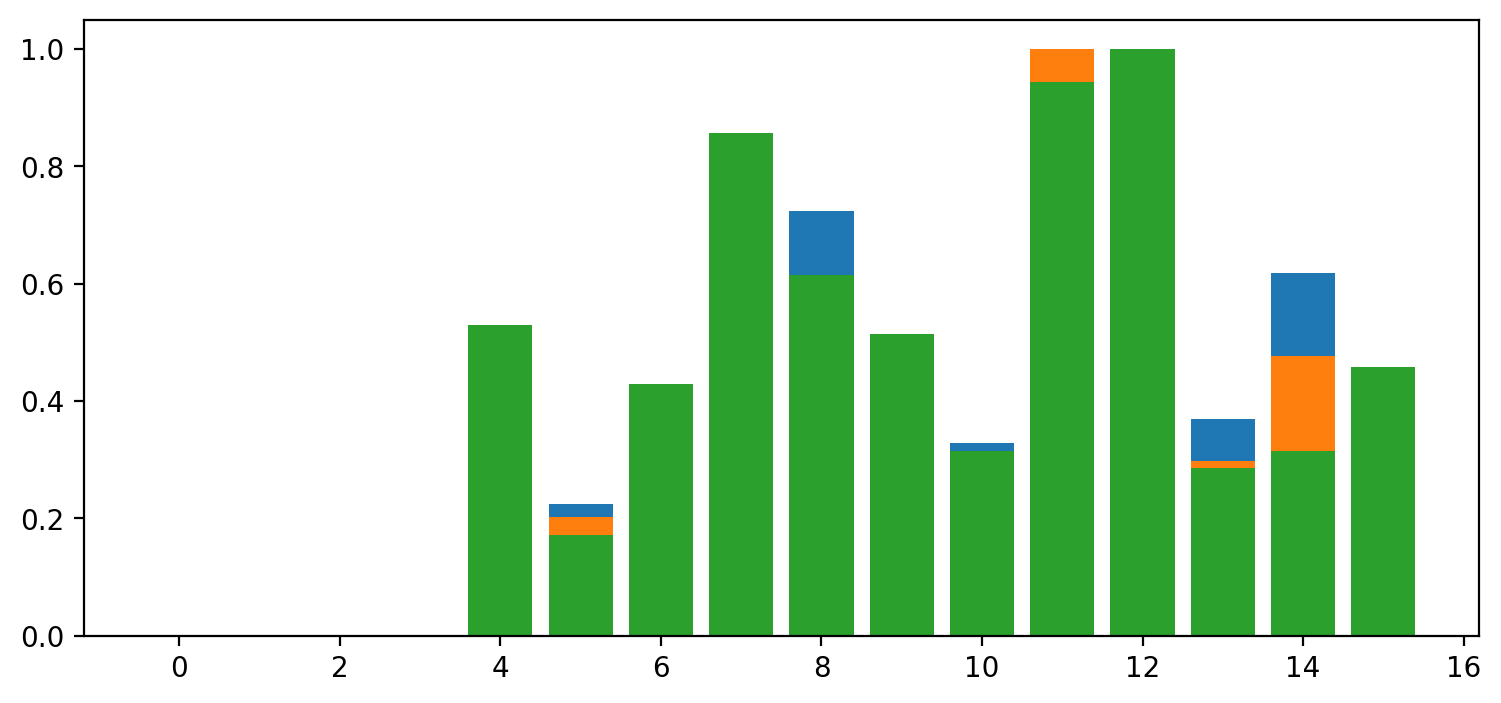

In [215]:
plt.figure(figsize=(9,4))
plt.bar(x=range(16), height = rgb_hist[:16].ravel())
plt.bar(x=range(16), height = rgb_hist[16:32].ravel())
plt.bar(x=range(16), height = rgb_hist[32:48].ravel())
plt.show()

In [216]:
train_hist = []
for image in train_data:
    train_hist.append(calc_hist(image))

In [217]:
test_hist = []
for image in test_data:
    test_hist.append(calc_hist(image))

In [218]:
X_train = pd.DataFrame(train_hist)
X_test = pd.DataFrame(test_hist)
y_train = pd.Series(train_labels)
y_test = pd.Series(test_labels)

In [219]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
1,0.000000,0.000000e+00,0.000000,0.000000,0.447368,0.223684,0.368421,0.671053,7.236842e-01,0.434211,...,0.428571,0.857143,0.614286,0.514286,3.142857e-01,0.942857,1.000000,0.285714,0.314286,0.457143
2,0.000000,0.000000e+00,0.000000,0.010309,0.000000,0.020619,0.010309,0.072165,6.701031e-01,0.515464,...,0.032609,0.097826,0.728261,0.608696,1.847826e-01,0.184783,0.847826,0.619565,1.000000,0.467391
3,0.775862,1.000000e+00,0.379310,0.224138,0.206897,0.224138,0.396552,0.586207,4.827586e-01,0.586207,...,0.543860,0.631579,0.526316,0.491228,2.456140e-01,0.719298,1.000000,0.631579,0.070175,0.000000
4,0.881890,2.992126e-01,0.244094,1.000000,0.181102,0.811024,0.125984,0.000000,0.000000e+00,0.000000,...,0.153846,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14029,0.420290,1.014493e-01,0.072464,0.202899,0.144928,0.115942,0.057971,0.000000,1.449275e-02,0.000000,...,0.095238,0.023810,0.047619,0.023810,-9.313226e-10,0.047619,0.047619,0.119048,0.071429,1.000000
14030,0.185897,1.000000e+00,0.384615,0.179487,0.217949,0.275641,0.121795,0.025641,-4.656613e-10,0.019231,...,0.191489,0.085106,0.035461,0.042553,3.546099e-02,0.042553,0.063830,0.028369,0.049645,0.000000
14031,0.279412,4.411765e-01,0.110294,0.110294,0.117647,0.110294,0.088235,0.110294,8.088236e-02,0.066176,...,0.156250,0.148438,0.125000,0.085938,7.031250e-02,0.125000,0.023438,0.000000,0.093750,1.000000
14032,1.000000,9.470199e-01,0.039735,0.000000,0.006623,0.112583,0.827815,0.046358,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.161538,6.230769e-01,0.369231,0.000000,0.000000,0.000000,0.000000


In [220]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.000000,0.000000,0.000000,0.036585,0.048780,0.097561,0.524390,0.439024,0.634146,0.707317,...,0.628205,0.384615,0.769231,0.641026,0.217949,0.205128,0.461538,0.269231,1.000000,0.756410
1,0.017857,0.044643,0.089286,0.151786,0.187500,0.133929,0.946429,0.187500,0.062500,0.053571,...,0.820513,0.188034,0.051282,0.094017,0.102564,1.000000,0.076923,0.692308,0.341880,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.016129,0.000000,0.010753,0.005376,0.000000,0.000000,0.043011,0.639785,1.000000,0.672043
3,0.010638,0.074468,0.000000,0.074468,0.095745,0.085106,0.085106,0.085106,0.159574,0.680851,...,0.079545,0.125000,0.215909,0.727273,0.704545,1.000000,0.363636,0.079545,0.318182,0.931818
4,0.000000,0.000000,1.000000,0.000000,0.033333,0.966667,0.000000,0.000000,0.106667,0.893333,...,0.000000,0.000000,0.013333,0.986667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.000000,0.000000,0.024631,0.078818,0.167488,0.157635,0.108374,0.152709,0.137931,0.147783,...,0.193548,0.112903,0.188172,0.193548,0.086022,0.086022,0.059140,0.016129,0.032258,1.000000
2996,0.046931,0.018051,0.018051,0.054152,0.061372,0.104693,0.115523,0.079422,0.028881,0.046931,...,0.072581,0.092742,0.032258,0.048387,0.032258,0.000000,0.032258,0.016129,0.000000,1.000000
2997,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.086667,...,0.000000,0.000000,0.000000,0.040000,0.593333,0.366667,0.000000,0.000000,0.000000,0.000000
2998,0.000000,0.000000,0.000000,0.000000,0.000000,0.012552,0.008368,0.025105,0.179916,0.104603,...,0.012712,0.000000,0.148305,0.059322,0.262712,1.000000,0.411017,0.000000,0.000000,0.000000


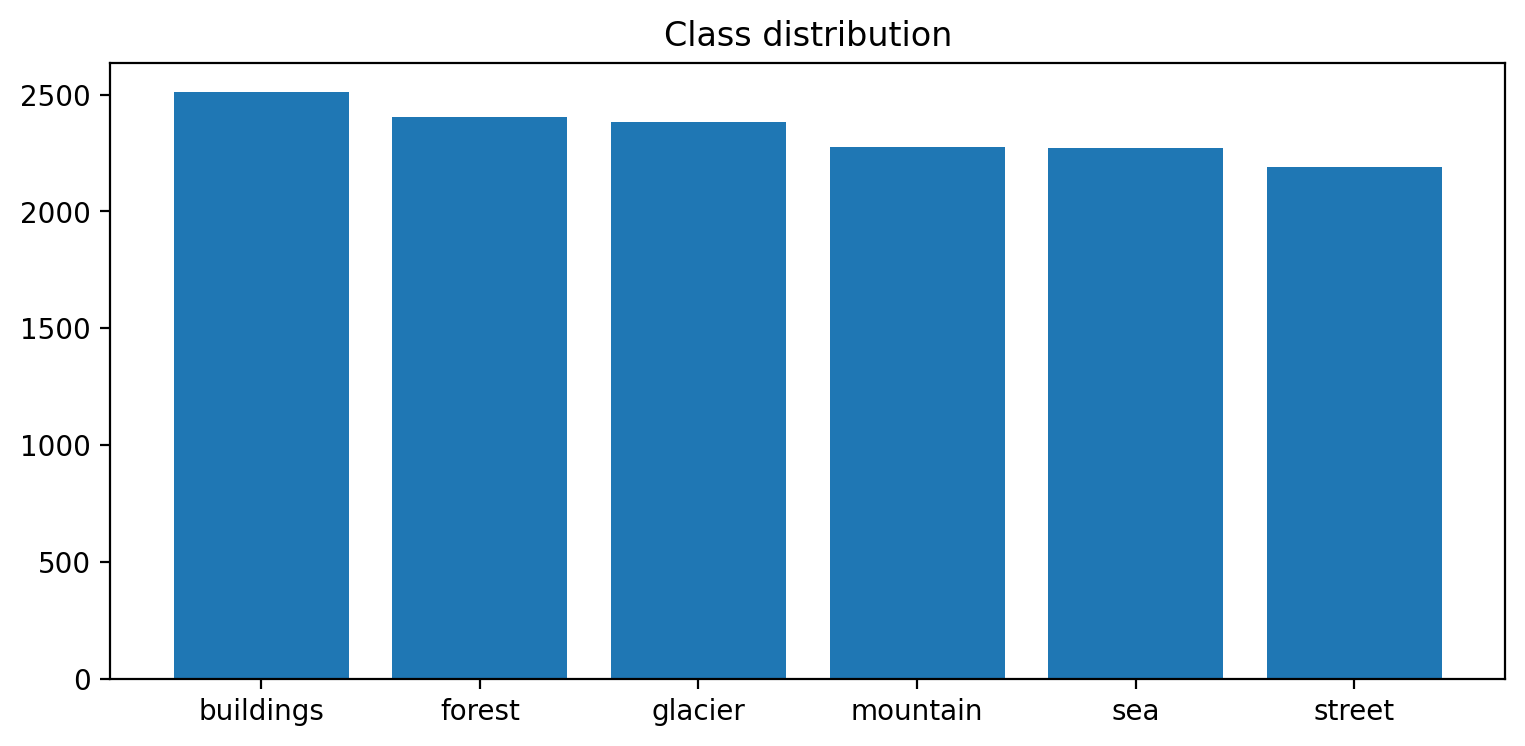

In [221]:
plt.figure(figsize=(9,4))
plt.bar(x=range(1,7), height=y_train.value_counts())
plt.xticks(range(1,7), ind2class.values())
plt.title("Class distribution")
plt.show()

In [222]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42, stratify=train_labels)

In [223]:
X_train.shape

(11227, 48)

In [224]:
X_val.shape

(2807, 48)

In [225]:
X_test.shape

(3000, 48)

## Logistic regression model

In [206]:
lr = LogisticRegression()

In [207]:
lr.fit(X_train, y_train)

LogisticRegression()

In [208]:
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)

In [209]:
y_pred

array([3, 3, 3, ..., 4, 3, 1], dtype=int64)

In [210]:
print(f"Accuracy {accuracy_score(y_test, y_pred): .4f}")

Accuracy  0.3097


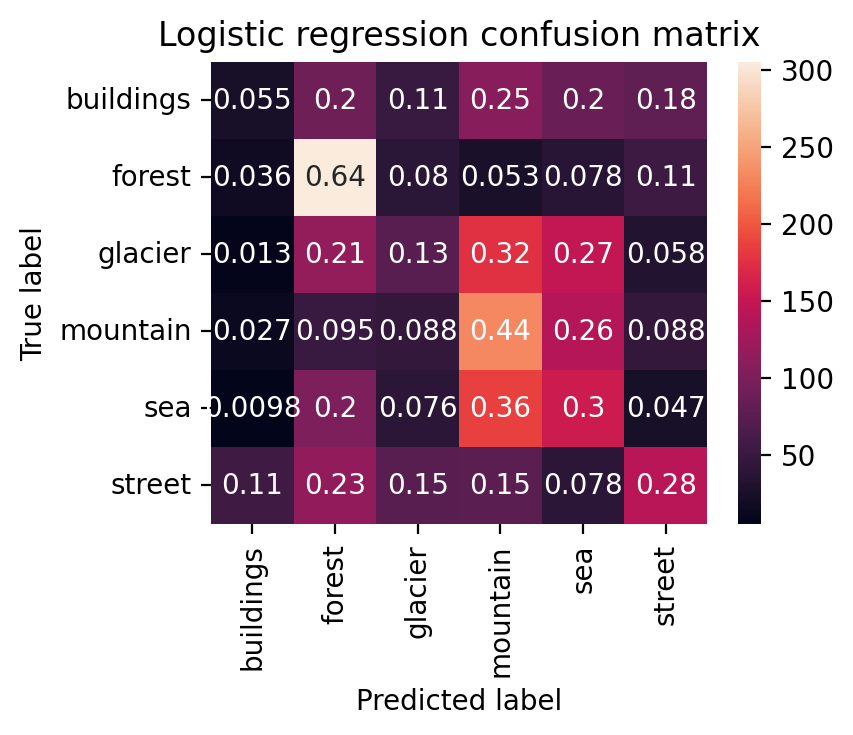

In [227]:
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3));
sns.heatmap(conf,
            annot=conf/conf.astype(np.float).sum(axis=1, keepdims=True), #normalized by true class sizes
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys());
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

In [228]:
print(classification_report(y_test, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.20      0.05      0.09       437
      forest       0.39      0.64      0.49       474
     glacier       0.23      0.13      0.17       553
    mountain       0.29      0.44      0.35       525
         sea       0.26      0.30      0.28       510
      street       0.38      0.28      0.32       501

    accuracy                           0.31      3000
   macro avg       0.29      0.31      0.28      3000
weighted avg       0.29      0.31      0.28      3000



<AxesSubplot: >

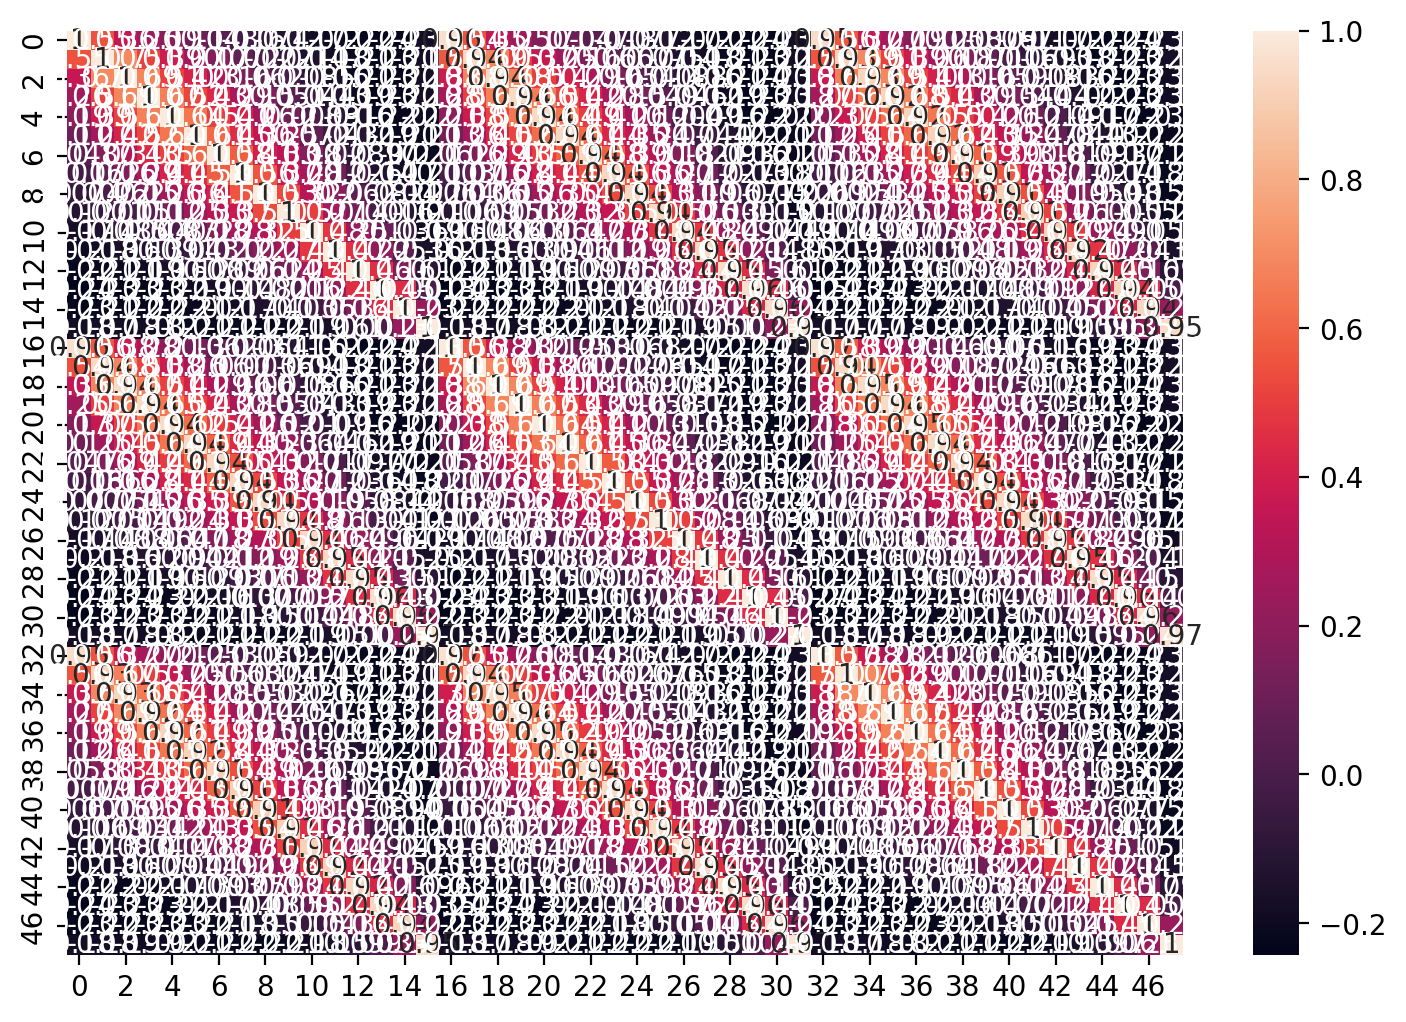

In [230]:
corr = X_train.corr()
sns.heatmap(corr, annot=True)

Features are highly correlated. Let's do PCA.

In [233]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)

In [235]:
X_train_pca.shape

(11227, 15)

In [238]:
X_test_pca = pca.transform(X_test)

### Tuning hyperparameters

In [240]:
lr.fit(X_train_pca, y_train)

LogisticRegression()

In [241]:
y_pred = lr.predict(X_test_pca)
y_prob = lr.predict_proba(X_test_pca)

In [242]:
print(f"Accuracy {accuracy_score(y_test, y_pred): .4f}")

Accuracy  0.3470


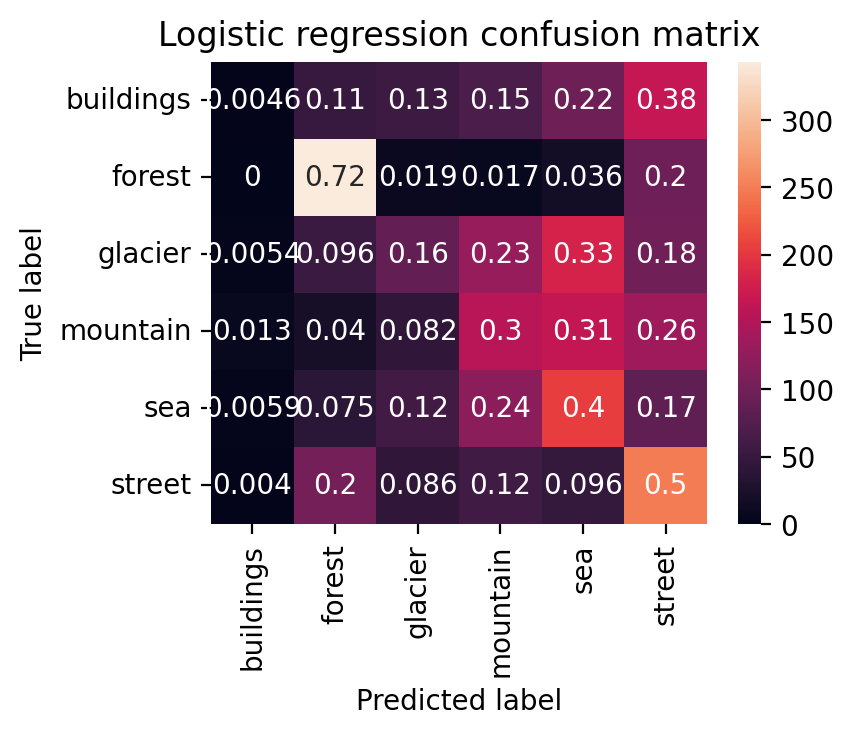

In [243]:
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3));
sns.heatmap(conf,
            annot=conf/conf.astype(np.float).sum(axis=1, keepdims=True), #normalized by true class sizes
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys());
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

### Using keypoints and descriptors

In [258]:
def get_keypoints(img, maxFeatures):
    # convert input image to grayscale
   imageGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # use ORB to detect keypoints and extract (binary) local
	# invariant features
   orb = cv2.ORB_create(maxFeatures)
	# extract keypoints and descriptors for image A
   (kps, descs) = orb.detectAndCompute(imageGray, None)
   if (kps is not None) and (descs is not None):
        output_image = cv2.drawKeypoints(img, kps, 0, (0, 0, 255),
                                 flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
        cv2.imshow("Keypoints", output_image)
        cv2.waitKey(0)

   return kps, descs


In [260]:
kps, descs = get_keypoints(train_data[0], 100)

In [262]:
len(descs)

56

# NN approach

### Create dataset of image folders

In [7]:
#make seed for the same randomness
torch.manual_seed(42)

In [8]:
train_path = "Classification_data/train/"
test_path = "Classification_data/test/"

In [9]:
train_transform = transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.RandomRotation((0,40)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop((150, 150), scale=(0.2, 1), ratio=(1, 1)),
    transforms.ToTensor(), #rescale image from (0-255) to (0,1)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalization from ImageNet
])


test_transform = transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# val_transform = transforms.Compose([
#     transforms.Resize(size=(150, 150)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

In [10]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
# val_dataset = datasets.ImageFolder(val_path, transform=val_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

In [11]:
BATCH_SIZE = 64

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
train_dataset.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [43]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.convolutional_layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #output 16x150x150
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.MaxPool2d(kernel_size=(2,2)),#output 16x75x75

            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 32x37x37

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 64x18x18

            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 128x9x9


        )

        #fully connected layer
        self.dense_layers = torch.nn.Sequential(
            nn.Flatten(),
            torch.nn.Linear(9*9*128, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes)
        )
    # fo
    def forward(self, X):
        out = self.convolutional_layers(X)
        out = self.dense_layers(out)
        return out

In [44]:
model = CNN(num_classes=6)

In [45]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimization of learning rate by factor 0.9 if there is no improvement for 5 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.9, patience=5, verbose=True)

In [46]:
def train_CNN(model, loss, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  train_accs=np.zeros(epochs)
  test_accs=np.zeros(epochs)

  for epoch in range(epochs):
    model.train()
    t0 = datetime.datetime.now()


    train_loss=[]
    train_correct, train_total = 0.0, 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        losses = loss(outputs, targets)
        losses.backward()
        optimizer.step()
        train_loss.append(losses.item())
        train_correct+=(outputs.argmax(axis=1)==targets).sum()
        train_total+=targets.shape[0]

    train_loss = np.mean(train_loss)



    model.eval()
    test_loss=[]
    test_correct, test_total = 0.0, 0.0
    for inputs, targets in test_loader:
        outputs = model(inputs).squeeze()
        losses = loss(outputs, targets)
        test_loss.append(losses.item())
        test_correct+=(outputs.argmax(axis=1)==targets).sum()
        test_total+=targets.shape[0]

    test_loss = np.mean(test_loss)
    #check the learning rate
    scheduler.step(test_loss)

    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    train_accs[epoch]= train_correct/train_total #overall accuracy per epoch
    test_accs[epoch]=test_correct/test_total

    dt = datetime.datetime.now() - t0
    print(f'Epoch {epoch+1}/{epochs}  Train Loss: {train_loss:.4f}  Train Acc: {train_correct/train_total: .4f} Val Loss: {test_loss:.4f} Val Acc: {test_correct/test_total: .4f} Duration: {dt}')

  return train_losses, test_losses, train_accs, test_accs

In [50]:
EPOCHS = 100
train_losses, val_losses, train_accs, val_accs = train_CNN(model, loss, optimizer, train_dataloader, test_dataloader,
                                                           EPOCHS)

Epoch 1/100  Train Loss: 1.3557  Train Acc:  0.5353 Val Loss: 0.7892 Val Acc:  0.7073 Duration: 0:03:01.889245
Epoch 2/100  Train Loss: 0.9891  Train Acc:  0.6345 Val Loss: 0.8405 Val Acc:  0.6890 Duration: 0:03:08.057704
Epoch 3/100  Train Loss: 0.9305  Train Acc:  0.6608 Val Loss: 0.7624 Val Acc:  0.7300 Duration: 0:03:07.440134
Epoch 4/100  Train Loss: 0.8564  Train Acc:  0.6880 Val Loss: 0.7546 Val Acc:  0.7380 Duration: 0:03:11.951672
Epoch 5/100  Train Loss: 0.8290  Train Acc:  0.7008 Val Loss: 0.6768 Val Acc:  0.7667 Duration: 0:03:14.693557
Epoch 6/100  Train Loss: 0.7906  Train Acc:  0.7128 Val Loss: 0.5983 Val Acc:  0.7953 Duration: 0:03:20.762151
Epoch 7/100  Train Loss: 0.7665  Train Acc:  0.7282 Val Loss: 0.6833 Val Acc:  0.7737 Duration: 0:03:15.307212
Epoch 8/100  Train Loss: 0.7404  Train Acc:  0.7403 Val Loss: 0.7307 Val Acc:  0.7490 Duration: 0:03:12.226473
Epoch 9/100  Train Loss: 0.7060  Train Acc:  0.7483 Val Loss: 0.5670 Val Acc:  0.7987 Duration: 0:03:12.345098
E

In [51]:
test_accs = val_accs
test_losses = val_losses

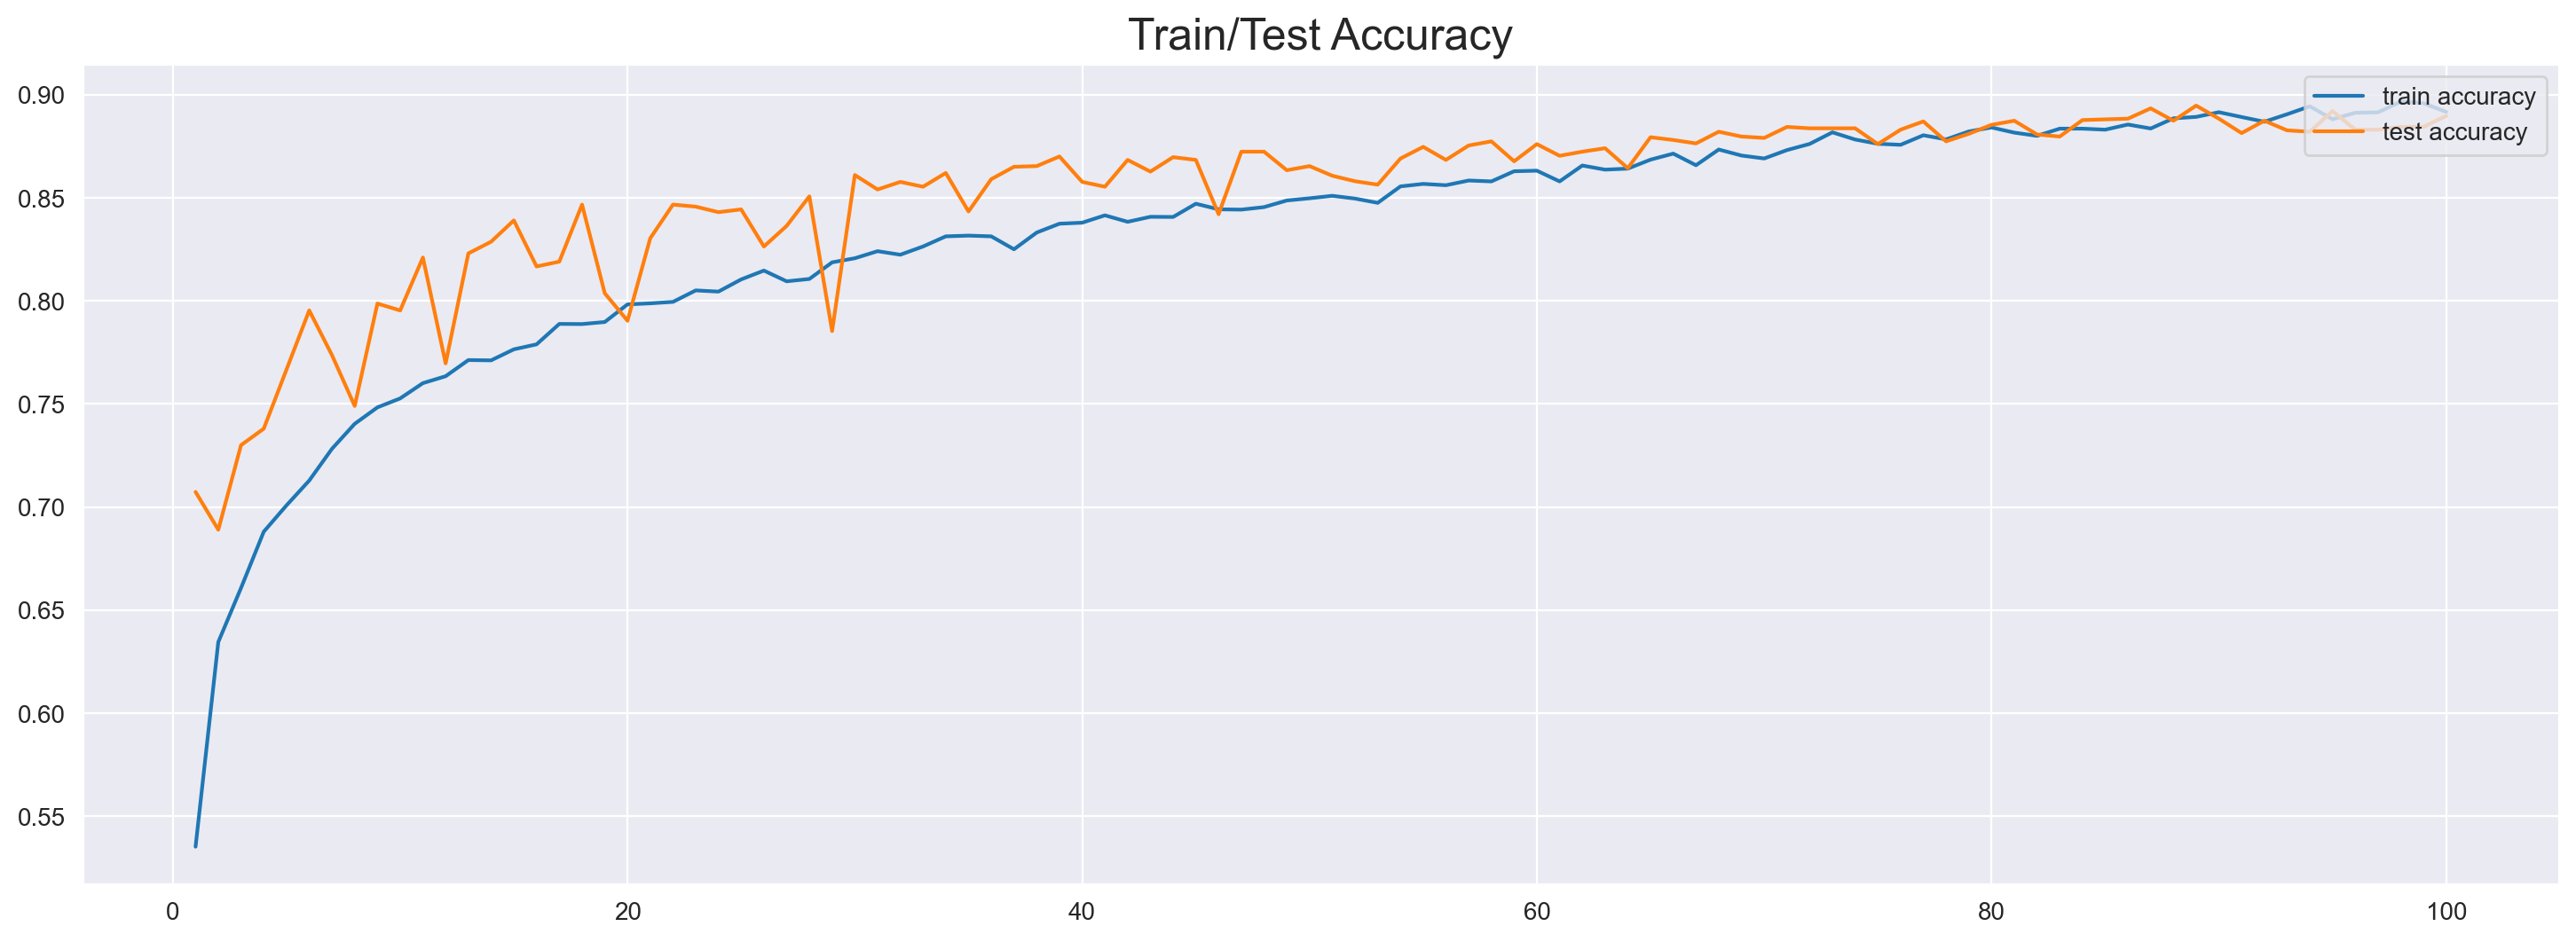

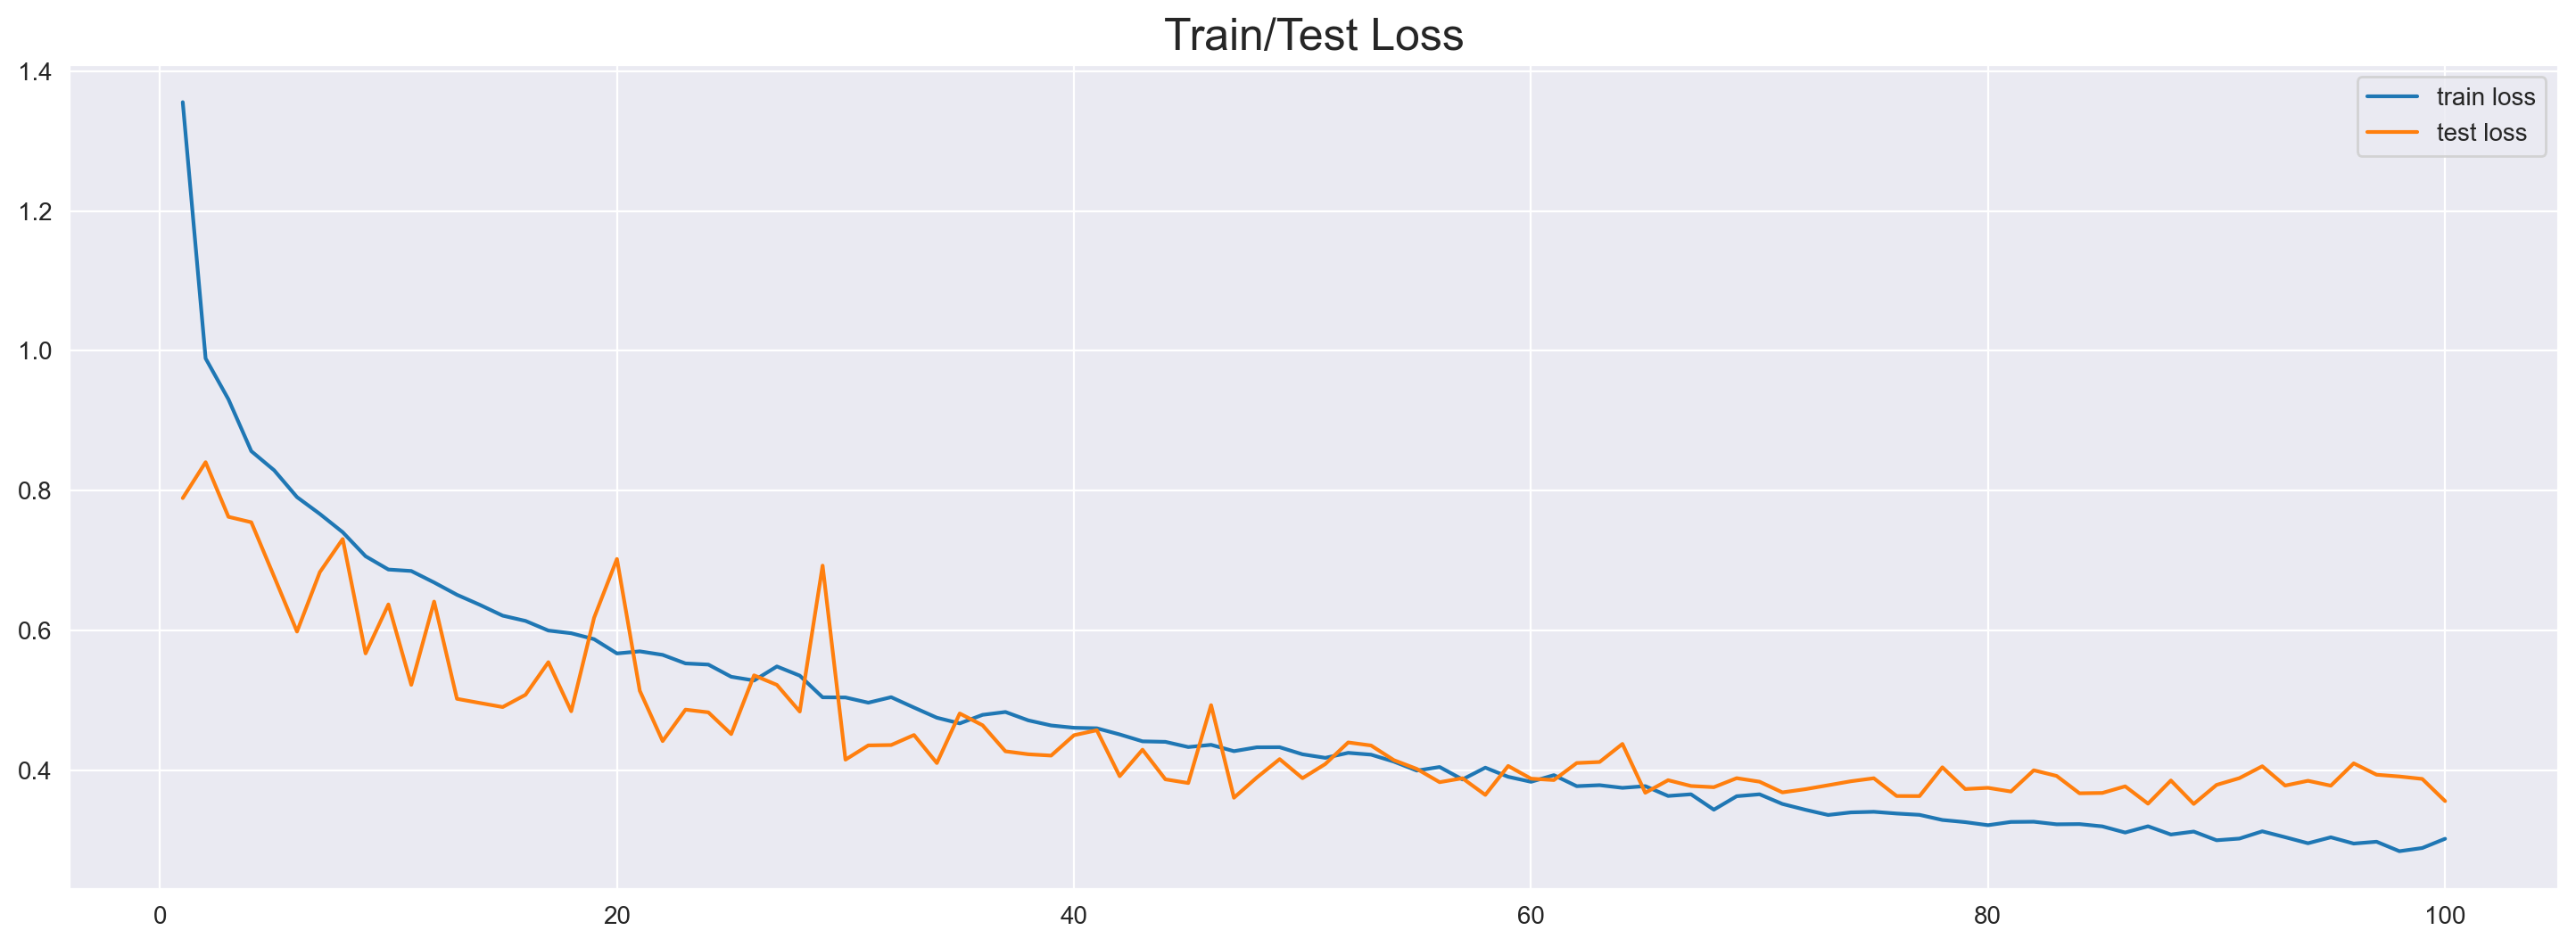

In [52]:
plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_accs, label='train accuracy')
plt.plot(range(1,EPOCHS+1), test_accs, label="test accuracy")
plt.legend(loc='upper right')
plt.title("Train/Test Accuracy", fontsize=18)
plt.show()

plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_losses, label='train loss')
plt.plot(range(1,EPOCHS+1), test_losses, label="test loss")
plt.legend(loc='upper right')
plt.title("Train/Test Loss", fontsize=18)
plt.show()

Save model

In [53]:
torch.save(model.state_dict(), "models/basic_CNN.pt")

Load model

In [54]:
model = CNN(num_classes=6)
model.load_state_dict(torch.load("models/basic_CNN.pt"))
model.eval()

CNN(
  (convolutional_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, mo

### Make prediction

In [55]:
X_test, labels = next(iter(test_dataloader))
#as we have logits after the last layer of model, we have to use softmax activation function to get the probabilities
softmax = nn.Softmax(dim=1)
output = model(X_test)
y_probs = softmax(output)
y_pred = y_probs.argmax(axis=1)